In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
!pwd

/Users/heymanjake/Documents/Flatiron/phase_4_project


In [3]:
!ls

Alzheimer_s Dataset  README.md
Image_analysis.ipynb Untitled.ipynb


In [4]:
!unzip archive\ \(2\).zip

unzip:  cannot find or open archive (2).zip, archive (2).zip.zip or archive (2).zip.ZIP.


In [5]:
!ls

Alzheimer_s Dataset  README.md
Image_analysis.ipynb Untitled.ipynb


In [6]:
!rm archive\ \(2\).zip

rm: archive (2).zip: No such file or directory


In [7]:
directory = 'Alzheimer_s Dataset/'

In [8]:
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(224, 224), 
        batch_size = 6400, 
        seed = 123)

Found 6400 images belonging to 2 classes.


In [9]:
test_directory = 'Alzheimer_s Dataset/test/'

In [10]:
train_directory = 'Alzheimer_s Dataset/train/'

In [11]:
data_test = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

Found 1279 images belonging to 4 classes.


In [12]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 5121, 
        seed = 123)

Found 5121 images belonging to 4 classes.


In [13]:
train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

In [14]:
data_train.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [15]:
data_test.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [16]:
sum(train_labels)

array([ 717.,   52., 2560., 1792.], dtype=float32)

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

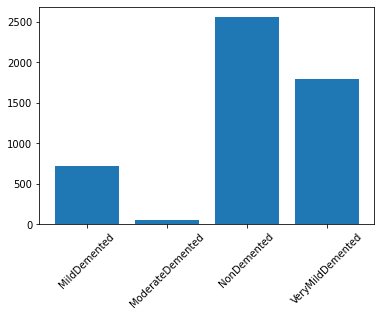

In [17]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(train_labels))
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

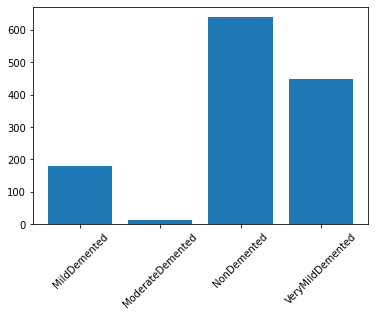

In [18]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(test_labels))
plt.xticks(rotation=45)

In [19]:
def get_label(array):
    if array[0] ==1:
        return 'MildDemented'
    elif array[1] ==1:
        return 'ModerateDemented'
    elif array[2] ==1:
        return 'NonDemented'
    elif array[3] ==1:
        return 'VeryMildDemented'
        
        

In [20]:
label_names = np.apply_along_axis(get_label,1,train_labels)

In [114]:
label_names[:9]

array(['NonDemented', 'NonDemented', 'NonDemented', 'VeryMildDem',
       'VeryMildDem', 'VeryMildDem', 'VeryMildDem', 'MildDemente',
       'MildDemente'], dtype='<U11')

In [115]:
train_labels[:9]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

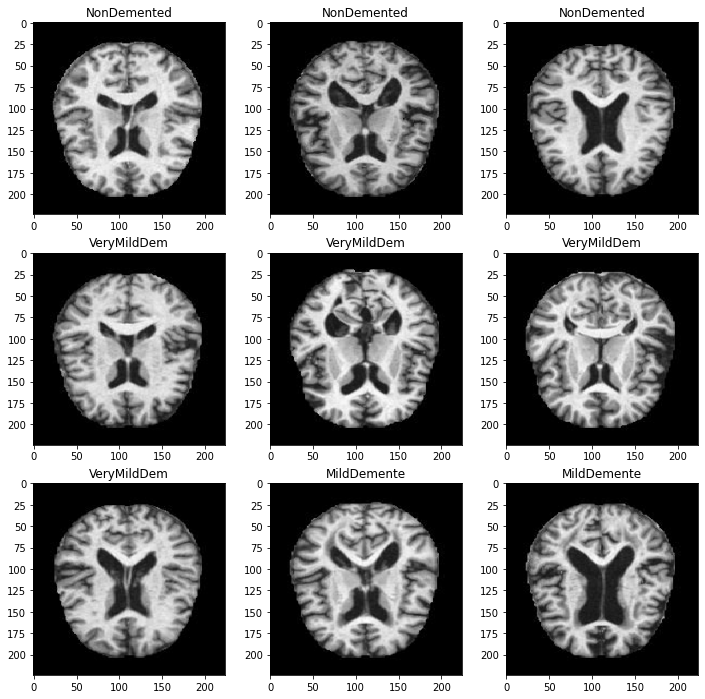

In [21]:
#visualize images

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images[i])
  plt.gca().set_title(label_names[i])
plt.show()

In [97]:
#import scipy.misc
#import matplotlib.image as img
#from PIL import Image
import imageio

In [23]:
#image_matrix = img.imread(train_images[0])
#i = Image.load(train_images[0])
#i = scipy.misc.imread(train_images[0])
#image_matrix = imageio.imread(train_images[0])
train_images[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [24]:
train_images[0][0][0]

array([0., 0., 0.], dtype=float32)

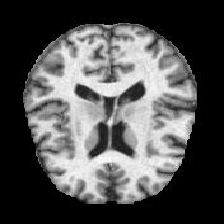

In [25]:
array_to_img(train_images[0])

In [26]:
train_images[0].shape

(224, 224, 3)

In [27]:
type(data_train)

keras_preprocessing.image.directory_iterator.DirectoryIterator

In [28]:
!cd Alzheimer_s\ Dataset
!ls

Alzheimer_s Dataset  README.md
Image_analysis.ipynb Untitled.ipynb


In [34]:
#isolated milddemented class images for eda
data_mild = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['MildDemented'])

mild_images, mild_labels = next(data_mild)

Found 717 images belonging to 1 classes.


In [37]:
data_moderate = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['ModerateDemented'])

moderate_images, moderate_labels = next(data_moderate)

Found 52 images belonging to 1 classes.


In [36]:
data_NonD = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2560, 
        seed = 123,
        classes= ['NonDemented'])

NonD_images, NonD_labels = next(data_NonD)

Found 2560 images belonging to 1 classes.


In [35]:
data_veryMild = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 1792, 
        seed = 123,
        classes= ['VeryMildDemented'])

veryMild_images, veryMild_labels = next(data_veryMild)

Found 1792 images belonging to 1 classes.


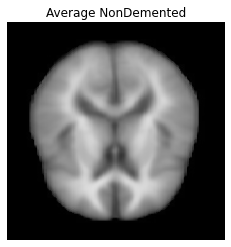

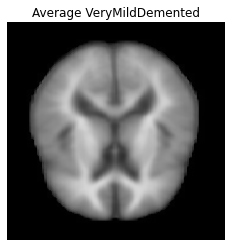

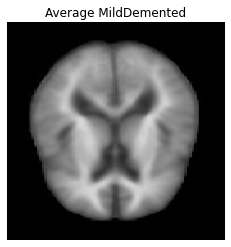

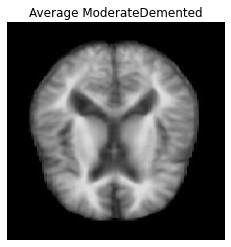

In [45]:
def find_mean_img(full_mat, title, size = (224, 224)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    #mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

NonD_mean = find_mean_img(NonD_images, 'NonDemented')
veryMild_mean = find_mean_img(veryMild_images, 'VeryMildDemented')
mild_mean = find_mean_img(mild_images, 'MildDemented')
Moderate_mean = find_mean_img(moderate_images, 'ModerateDemented')



In [41]:
NonD_images.shape

(2560, 224, 224, 3)

In [42]:
np.mean(NonD_images,axis=0).shape

(224, 224, 3)

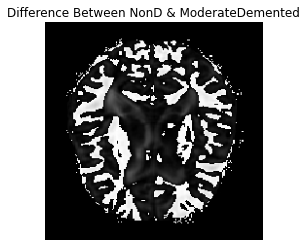

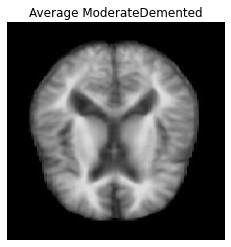

In [110]:
contrast_mean = NonD_mean - Moderate_mean
plt.imshow((contrast_mean*255).astype(np.uint8), cmap='pink')
plt.title(f'Difference Between NonD & ModerateDemented')
plt.axis('off')
plt.show()
Moderate_mean = find_mean_img(moderate_images, 'ModerateDemented')

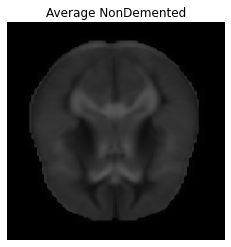

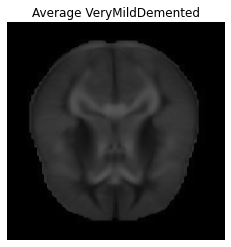

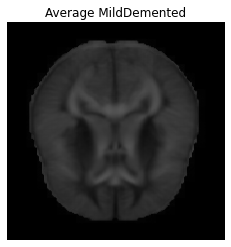

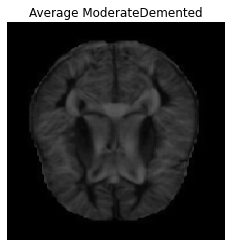

In [56]:
def find_std_img(full_mat, title, size = (224, 224)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    #mean_img = mean_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return std_img

NonD_std = find_std_img(NonD_images, 'NonDemented')
veryMild_std = find_std_img(veryMild_images, 'VeryMildDemented')
mild_std = find_std_img(mild_images, 'MildDemented')
Moderate_std = find_std_img(moderate_images, 'ModerateDemented')

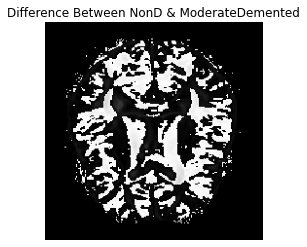

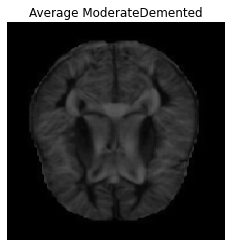

In [57]:
contrast_std = NonD_std - Moderate_std
plt.imshow((contrast_std*255).astype(np.uint8), cmap='pink')
plt.title(f'Difference Between NonD & ModerateDemented')
plt.axis('off')
plt.show()
Moderate_std = find_std_img(moderate_images, 'ModerateDemented')

In [58]:
from sklearn.decomposition import PCA
from math import ceil

In [61]:
NonD_images.shape[0]

2560

In [73]:
def eigenimages(full_mat, title, n_comp = 0.7):
    # fit PCA to describe n_comp * variability in the class
    size = (full_mat.shape[0],(224*224*3))
    array = np.reshape(full_mat, size)
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(array)
    print('Number of PC: ', pca.n_components_)
    return pca
  

    
non_eigan = eigenimages(NonD_images, 'NORMAL')
moderate_eigan= eigenimages(moderate_images, 'Moderate')

Number of PC:  81
Number of PC:  5


In [95]:
non_eigan.explained_variance_ratio_

array([0.20081809, 0.09191748, 0.07719012, 0.02557673, 0.02152169,
       0.01616029, 0.0132946 , 0.01012931, 0.00931473, 0.00760683,
       0.00711772, 0.0068731 , 0.00623402, 0.00594163, 0.00551502,
       0.00539256, 0.00536175, 0.00496188, 0.00479661, 0.00469175,
       0.00447006, 0.00435372, 0.00419946, 0.00414261, 0.00405661,
       0.00394229, 0.00389563, 0.00371678, 0.00365414, 0.00360357,
       0.00350825, 0.00343722, 0.00338546, 0.00335058, 0.00332207,
       0.00325085, 0.00321276, 0.00316671, 0.00314535, 0.00309051,
       0.00303605, 0.00297404, 0.00296781, 0.00288031, 0.00283647,
       0.00280893, 0.00279443, 0.00272279, 0.00271013, 0.00266306,
       0.00264364, 0.00260281, 0.00253874, 0.00252138, 0.00250444,
       0.00247585, 0.00244412, 0.00242415, 0.00240757, 0.00233929,
       0.00232672, 0.00230765, 0.00229464, 0.00226519, 0.00221576,
       0.00220314, 0.00217986, 0.00212733, 0.00211754, 0.00210667,
       0.00205241, 0.0020372 , 0.00203362, 0.00201468, 0.00199

In [96]:
moderate_eigan.explained_variance_ratio_

array([0.2980785 , 0.16533564, 0.12617505, 0.06732558, 0.06491658],
      dtype=float32)

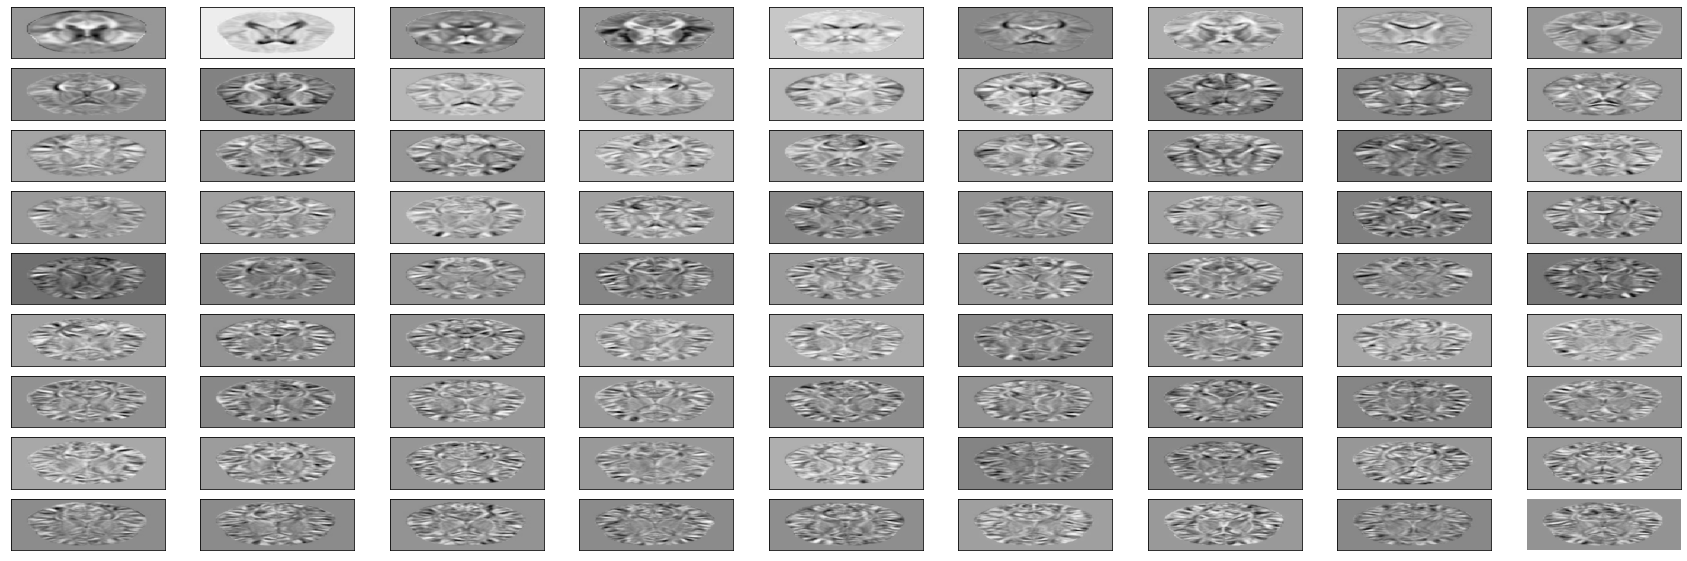

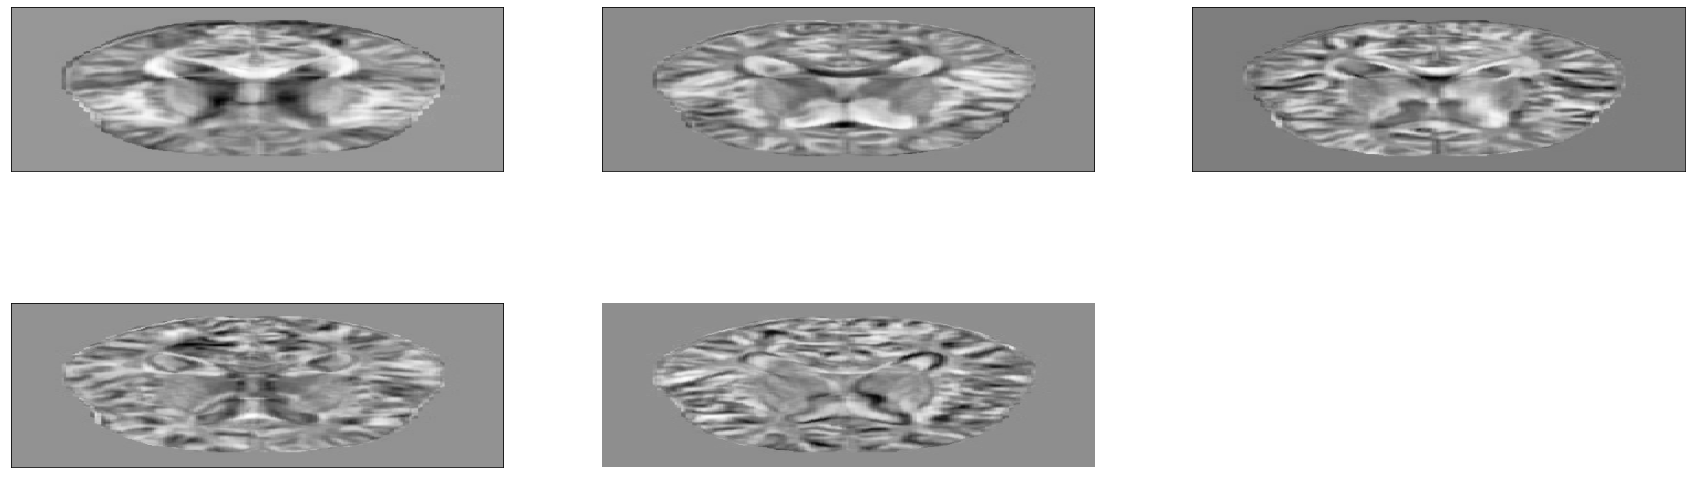

In [112]:
def plot_pca(pca):
    # plot eigenimages in a grid
    
    n = pca.n_components_
    fig = plt.figure(figsize=(30, 10))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(224,224*3), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
plot_pca(non_eigan)
plot_pca(moderate_eigan)

In [102]:
from skimage.feature import hog
from skimage import exposure

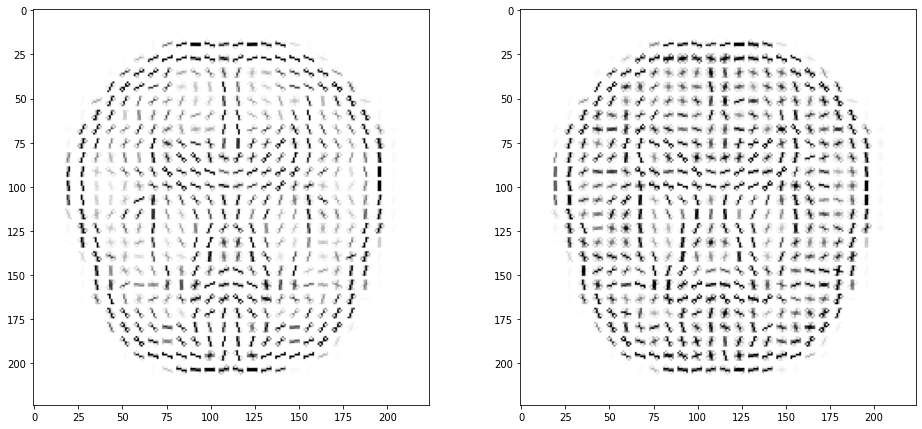

In [105]:
#histogram of oriented gradients
fd_NonD, NonD_hog = hog(NonD_mean, orientations=8, pixels_per_cell=(8,8),
                       cells_per_block=(3,3),visualize=True)
fd_moderate, moderate_hog = hog(Moderate_mean, orientations=8, pixels_per_cell=(8,8),
                       cells_per_block=(3,3),visualize=True)

NonD_hogs = exposure.rescale_intensity(NonD_hog, in_range=(0,0.04))
moderate_hogs = exposure.rescale_intensity(moderate_hog, in_range=(0,0.04))


fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(NonD_hogs, cmap='binary')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(moderate_hogs, cmap='binary')